In [1]:
import json
import pathlib

import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import torch

import hier
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
hierarchy_file = 'resources/hierarchy/inat21.csv'

# config_file = '/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20/config.json'
# model_file = '/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20/checkpoints/epoch-0020.pth'

config_file = '/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20/config.json'
model_file = '/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini/share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20/checkpoints/epoch-0020.pth'

with open(config_file, 'r') as f:
    config = ml_collections.ConfigDict(json.load(f))

with open(hierarchy_file, 'r') as f:
    tree, node_keys = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [3]:
num_outputs = main.get_num_outputs(config.predict, tree)
net = main.make_model(config.model, num_outputs)
missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)

In [4]:
missing_keys

[]

In [5]:
unexpected_keys

[]

In [6]:
device = torch.device('cuda')
net.to(device)
loss_fn, pred_fn = main.make_loss(config, tree, device)

In [7]:
train_dataset, eval_dataset, tree, _, train_label_map, eval_label_map = main.make_datasets(config)

In [8]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0)

In [9]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)

In [10]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
}

In [11]:
# Per-example predictions.
outputs = {
    'gt': [],  # Node in hierarchy.
    'pred': {method: [] for method in infer_fns},
}
# Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
seq_outputs = {
    'pred': [],
    'prob': [],
}

net.eval()
with torch.inference_mode():
    meter = progmet.ProgressMeter(f'eval', interval_time=5, num_div=5)
    for minibatch in meter(eval_loader):
        inputs, gt_labels = minibatch
        theta = net(inputs.to(device))
        prob = pred_fn(theta).cpu().numpy()
        pred = {}
        for name, infer_fn in infer_fns.items():
            pred[name] = infer_fn(prob)
        gt_node = eval_label_map.to_node[gt_labels]
        pred_seqs = [
            infer.pareto_optimal_predictions(specificity, p, 0., not_trivial)
            for p in prob
        ]
        prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
        # Caution: Predictions are *not* truncated.

        outputs['gt'].append(gt_node)
        for method in infer_fns:
            outputs['pred'][method].append(pred[method])
        seq_outputs['pred'].extend(pred_seqs)
        seq_outputs['prob'].extend(prob_seqs)

# Concatenate results from minibatches.
leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

eval:   1% (4/391); T=1.38 f=0.725; mean T=1.38 f=0.725; elapsed 0:00:06; remaining 0:08:53 of 0:08:59
eval:   2% (8/391); T=1.39 f=0.719; mean T=1.38 f=0.722; elapsed 0:00:11; remaining 0:08:50 of 0:09:01
eval:   3% (12/391); T=1.37 f=0.728; mean T=1.38 f=0.724; elapsed 0:00:17; remaining 0:08:43 of 0:09:00
eval:   4% (16/391); T=1.39 f=0.720; mean T=1.38 f=0.723; elapsed 0:00:22; remaining 0:08:39 of 0:09:01
eval:   5% (20/391); T=1.39 f=0.721; mean T=1.38 f=0.723; elapsed 0:00:28; remaining 0:08:33 of 0:09:01
eval:   6% (24/391); T=1.42 f=0.704; mean T=1.39 f=0.719; elapsed 0:00:33; remaining 0:08:30 of 0:09:04
eval:   7% (28/391); T=1.44 f=0.694; mean T=1.40 f=0.716; elapsed 0:00:39; remaining 0:08:27 of 0:09:06
eval:   8% (32/391); T=1.45 f=0.689; mean T=1.40 f=0.712; elapsed 0:00:45; remaining 0:08:24 of 0:09:09
eval:   9% (36/391); T=1.40 f=0.713; mean T=1.40 f=0.712; elapsed 0:00:51; remaining 0:08:18 of 0:09:09
eval:  10% (40/391); T=1.42 f=0.707; mean T=1.41 f=0.712; elapsed 

eval:  80% (313/391); T=1.30 f=0.772; mean T=1.43 f=0.697; elapsed 0:07:29; remaining 0:01:52 of 0:09:21
eval:  81% (317/391); T=1.37 f=0.732; mean T=1.43 f=0.697; elapsed 0:07:35; remaining 0:01:46 of 0:09:21
eval:  82% (321/391); T=1.33 f=0.750; mean T=1.43 f=0.698; elapsed 0:07:40; remaining 0:01:40 of 0:09:20
eval:  83% (325/391); T=1.46 f=0.684; mean T=1.43 f=0.698; elapsed 0:07:46; remaining 0:01:35 of 0:09:20
eval:  84% (329/391); T=1.41 f=0.711; mean T=1.43 f=0.698; elapsed 0:07:51; remaining 0:01:29 of 0:09:20
eval:  85% (333/391); T=1.45 f=0.690; mean T=1.43 f=0.698; elapsed 0:07:57; remaining 0:01:23 of 0:09:20
eval:  86% (337/391); T=1.29 f=0.776; mean T=1.43 f=0.699; elapsed 0:08:02; remaining 0:01:17 of 0:09:20
eval:  87% (341/391); T=1.30 f=0.771; mean T=1.43 f=0.700; elapsed 0:08:07; remaining 0:01:11 of 0:09:19
eval:  88% (345/391); T=1.26 f=0.793; mean T=1.43 f=0.700; elapsed 0:08:13; remaining 0:01:06 of 0:09:18
eval:  90% (350/391); T=1.26 f=0.796; mean T=1.43 f=0.7

In [12]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

In [13]:
gt = outputs['gt']
pred = outputs['pred']
pred_seq = seq_outputs['pred']
prob_seq = seq_outputs['prob']

In [14]:
# Evaluate metrics for each inference method.

# First truncate predictions at LCA with ground-truth.
# (No impact if gt are all leaf nodes.)
pred = {
    method: hier.truncate_at_lca(tree, gt, pr)
    for method, pr in pred.items()
}

metric_values = {
    method: {field: np.mean(metric_fn(gt, pr))
             for field, metric_fn in metric_fns.items()}
    for method, pr in pred.items()
}

In [15]:
# Evaluate metrics for Pareto sequence.
find_lca = hier.FindLCA(tree)
pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
metric_values_seq = {
    field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
    for field, metric_fn in metric_fns.items()
}

In [16]:
step_scores, step_totals = metrics.operating_curve(prob_seq, metric_values_seq)
step_means = {k: v / len(gt) for k, v in step_totals.items()}

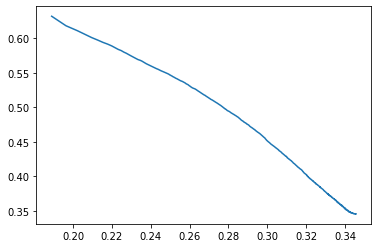

In [18]:
plt.plot(step_means['exact'], step_means['correct'])